# Towards Scalable Fraud Detection:The Role of Oversampling and Hybrid Techniques in Distirbuted Data Environment

This project applies scalable machine learning techniques for fraud detection on large-scale credit card transaction data. It leverages Apache Spark to handle partitioning, SMOTE-based oversampling, and distributed evaluation efficiently.



- **Source:** [Kaggle Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud)
- 284,807 transactions with 492 frauds (~0.17%)
- Features are PCA-transformed (V1–V28), plus `Time` and `Amount`


#### Overview of the Pipeline
- Data loading and preprocessing
- Partitioning strategies
- Multiple SMOTE techniques
- Model training and evaluation
- Scalability and performance analysis


### Author
 Project by:

1.   **Elakia Vijayalakshmi Mantharchalam**
2.   **Dias Kuatbekov**
3.   **Rustam Guliyev**


- Module: Big Data Learning and Technologies (COMP4124 UNUK)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Spark Setup and Library Imports

Imports all necessary libraries for data processing, machine learning, clustering, and visualization. Also initializes the Spark session.


In [2]:
##############################
# 1. Imports and Spark Setup #
##############################
from pyspark.sql import SparkSession,Row
from pyspark.sql.functions import col, when, unix_timestamp
from pyspark.ml.feature import VectorAssembler, BucketedRandomProjectionLSH
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import DenseVector, Vectors
from pyspark.broadcast import Broadcast
from sklearn.neighbors import NearestNeighbors
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, LongType, ArrayType, DoubleType
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import BucketedRandomProjectionLSH
from pyspark.sql.functions import col
from pyspark.ml.linalg import DenseVector
import numpy as np
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time
import math
from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as F
from pyspark.ml import Pipeline # Import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler

spark = SparkSession.builder.appName("CreditCardFraudDetection").getOrCreate()


### Load and Visualize Dataset

+-----+------+
|Class| count|
+-----+------+
|    1|   492|
|    0|284315|
+-----+------+

+-------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+
|summary|              Time|                  V1|                  V2|                  V3|                  V4|                  V5|                  V6|                  V7|                  V8|                  V9|                 V10|              

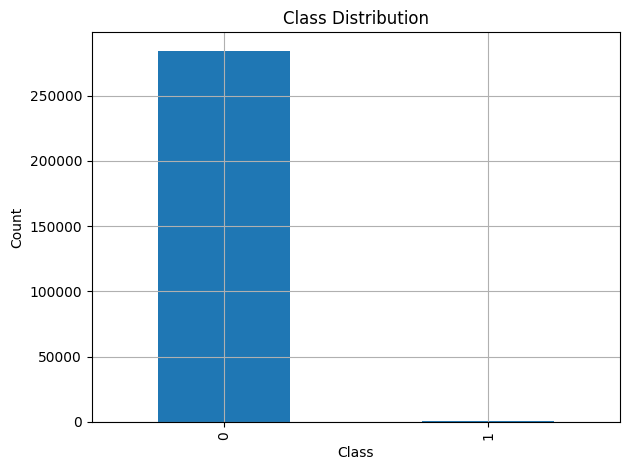

In [3]:

##############################
# 2. Dataset Visualization   #
##############################
raw_df = spark.read.csv("/content/drive/MyDrive/big data/creditcard.csv", header=True, inferSchema=True).dropna()
raw_df.select("Class").groupBy("Class").count().show()
raw_df.describe().show()

# Visualization
pandas_df = raw_df.select("Class").toPandas()
class_counts = pandas_df["Class"].value_counts()
class_counts.plot(kind="bar", title="Class Distribution", xlabel="Class", ylabel="Count")
plt.grid(True)
plt.tight_layout()
plt.show()

###  Data Preprocessing

- Splits the dataset into train and test sets using stratified sampling based on the label.
- Excludes `Time`, `ID`, and `Class` from feature columns.
- Uses `VectorAssembler` to combine features into a single vector.
- Applies `StandardScaler` to normalize feature values.
- Returns transformed train and test datasets with a `features` column.


In [4]:
##############################
# 2. Data Preprocessing      #
##############################

def train_test_split(df, label_col="Class", train_ratio=0.7):
    df = df.withColumn("ID", F.monotonically_increasing_id())
    feature_cols = [c for c in df.columns if c not in [label_col, "ID", "Time"]]

    window_spec = Window.partitionBy(F.col(label_col)).orderBy(F.rand(seed=42))
    df_ranked = df.withColumn("rank", F.percent_rank().over(window_spec))

    df_train = df_ranked.where(col("rank") <= train_ratio).drop("rank")
    df_test = df_ranked.where(col("rank") > train_ratio).drop("rank")

    df_train = df_train.drop("ID")
    df_test = df_test.drop("ID")

    return df_train, df_test


def preprocess_pipeline(df, label_col="Class"):

    # df = df.drop("Time")

    df_train, df_test = train_test_split(df, label_col=label_col)

    feature_cols = [c for c in df_train.columns if c not in [label_col, "ID"]]

    # Stage 1: Assemble features
    assembler = VectorAssembler(inputCols=feature_cols,
                                outputCol="assembled_features",
                                handleInvalid="skip") # Or other strategy

    # Stage 2: Scale features
    scaler = StandardScaler(inputCol="assembled_features",
                          outputCol="features", # Final features column name
                          withStd=True,
                          withMean=True)

    # Create the pipeline
    pipeline = Pipeline(stages=[assembler, scaler])

    # --- Fit and Transform ---
    print("\n--- Fitting Pipeline on Training Data ---")
    pipelineModel = pipeline.fit(df_train)

    print("\n--- Transforming Train and Test Data ---")
    train_processed = pipelineModel.transform(df_train).select("Time", "features", label_col)
    test_processed = pipelineModel.transform(df_test).select("Time", "features", label_col)

    print("\nPreprocessing Complete.")
    return train_processed, test_processed, feature_cols


### Train-Test Split Function

In [5]:
train_df, test_df, feature_cols = preprocess_pipeline(raw_df)


--- Fitting Pipeline on Training Data ---

--- Transforming Train and Test Data ---

Preprocessing Complete.


### Partitioning Strategies
- **Label-Aware Partitioning**: Separates data into minority and majority classes, then merges them to preserve label balance.
- **Time-Based Partitioning**: Splits data based on transaction time into equal intervals (`n_partitions`), then removes the time-related columns.
- **KMeans Partitioning**: Applies KMeans clustering to group data into `k` clusters using feature similarity.
- **Bisecting KMeans Partitioning**: Uses hierarchical clustering to divide data into `k` clusters with more balanced structure.

In [6]:
##############################
# 3. Partitioning Strategies #
##############################

def label_aware_partitioning(df):
    minor = df.filter(col("Class") == 1)
    major = df.filter(col("Class") == 0)
    return minor.union(major)

def time_based_partitioning(df, n_partitions: int):
    if "Time" not in df.columns:
        raise ValueError("DataFrame must contain a 'Time' column for time-based partitioning.")

    max_time = df.agg(F.max("Time").alias("max_time")).collect()[0]["max_time"]
    interval = max_time / n_partitions

    df_partitioned = df.withColumn(
        "time_bucket",
        F.floor(col("Time") / interval).cast("int")
    )

    df_partitioned = df_partitioned.withColumn(
        "time_bucket",
        when(col("time_bucket") >= n_partitions, n_partitions - 1).otherwise(col("time_bucket"))
    )

    df_partitioned = df_partitioned.drop("Time")
    df_partitioned = df_partitioned.drop("time_bucket")

    return df_partitioned

def kmeans_partitioning(df, k=6):
    model = KMeans(k=k, seed=42, featuresCol="features", predictionCol="cluster").fit(df)
    return model.transform(df)

def bisecting_kmeans_partitioning(df, k=6):
    model = BisectingKMeans(k=k, seed=42, featuresCol="features", predictionCol="cluster").fit(df)
    return model.transform(df)

### Different SMOTE techniques

- **Local SMOTE**: Generates synthetic minority points by random interpolation within the same partition or cluster.
- **SMOTE + ENN**: Applies SMOTE for oversampling and ENN to clean overlapping/noisy samples using k-nearest neighbor filtering.
- **Approximate SMOTE with LSH**: Uses Locality Sensitive Hashing to find approximate neighbors efficiently, then creates synthetic points by averaging neighbor pairs.



In [7]:
##############################
# 4. SMOTE Techniques        #
##############################

def smote_interpolation(x, y):
    return Vectors.dense([x[i] + random.random() * (y[i] - x[i]) for i in range(len(x))])

def local_smote(df):
    minority = df.filter(col("Class") == 1).collect()
    synthetic = []
    # Get the list of columns for later use
    columns = df.columns
    for x in minority:
        for _ in range(2):
            y = random.choice(minority)
            # If 'cluster' column exists in df, add it to the synthetic data
            if 'cluster' in columns:
                synthetic.append((smote_interpolation(x.features, y.features), 1, x['cluster']))
            else:  # Handle cases without 'cluster' column
                synthetic.append((smote_interpolation(x.features, y.features), 1))

    # Use the extracted column names to create synth_df
    synth_df = spark.createDataFrame(synthetic, columns if 'cluster' in columns else ["features", "Class"])
    return df.union(synth_df)

def apply_enn_smote(df, feature_cols):

    # Convert Spark DataFrame to Pandas
    pdf = df.toPandas()
    X = np.array(pdf["features"].tolist())
    y = pdf["Class"]

    # Apply SMOTE + ENN
    smote_enn = SMOTEENN(random_state=42)
    X_res, y_res = smote_enn.fit_resample(X, y)

    # Create Pandas DataFrame with resampled data
    df_resampled = pd.DataFrame(X_res, columns=feature_cols)
    df_resampled["Class"] = y_res

    # Convert back to Spark DataFrame
    spark_df = spark.createDataFrame(df_resampled)

    # Reassemble vector column using VectorAssembler
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    vector_df = assembler.transform(spark_df).select("features", "Class")

    return vector_df


def approx_smote_lsh(df, bucket_length=2.0, num_hash_tables=3, distance_threshold=1.5):

    # Step 1: Filter minority class
    minority_df = df.filter(col("Class") == 1)
    if minority_df.count() < 2:
        print("Not enough minority samples to apply LSH. Returning original.")
        return df

    # Step 2: Apply LSH
    lsh = BucketedRandomProjectionLSH(
        inputCol="features",
        outputCol="hashes",
        bucketLength=bucket_length,
        numHashTables=num_hash_tables
    )
    lsh_model = lsh.fit(minority_df)
    lsh_trans = lsh_model.transform(minority_df)

    # Step 3: Find approximate neighbors
    neighbors = lsh_model.approxSimilarityJoin(
        lsh_trans, lsh_trans, distance_threshold, distCol="distance"
    ).filter("datasetA.features != datasetB.features")

    # Step 4: Interpolate vectors to create synthetic samples
    def interpolate_vectors(row):
        v1 = np.array(row['datasetA']['features'])
        v2 = np.array(row['datasetB']['features'])
        return (DenseVector(((v1 + v2) / 2).tolist()), 1)

    interpolated = neighbors.rdd.map(interpolate_vectors)

    # Step 5: Check if RDD is empty
    if interpolated.isEmpty():
        print("Warning: No synthetic samples generated by Approx SMOTE. Returning original.")
        return df

    # Step 6: Create DataFrame and combine
    synthetic_df = interpolated.toDF(["features", "Class"])
    return df.union(synthetic_df)


#### Global SMOTE

- Implements a scalable, exact version of SMOTE for Spark.
- Uses broadcast variables to share minority class features and sampling plans.
- Performs global k-NN search across all partitions.
- Generates synthetic samples via random interpolation with neighbors.
- Returns a balanced DataFrame by appending synthetic samples to the original data.




In [8]:
class SMOTEExactGlobal:
  def __init__(self, k=5, sampling_ratio = 1.0, seed=0, verbosity=1):
    self.k = k
    self.sampling_ratio = sampling_ratio
    self.seed = seed
    self.verbosity = verbosity


  def _find_neighbors(self, iterator, broadcast_feats, k):
    """
      Helper function to do k nearest neighbors for points in particular partition
      against globally broadcasted variables

      To be called from rdd.MapPartitions

      Args:
        iterator: iterator over the rows of the current partition
        which is expected to have 'gid' and 'features'
        broadcast_feats: contains dict {'global id (gid)' : 'features as np arrays'}
                        for minority instances
        k: number of neighbors to find

      Yields:
        tuple: (id, [neighbor ids])
    """

    # features and ids of all minority data
    minority = broadcast_feats.value

    # accessing the dict
    feats_np = np.array([item[1] for item in minority])
    ids = [item[0] for item in minority]

    # to account for the casew when
    effective_k = min(k, len(ids))

    # sklearn will return the point itself as a neighor
    # so we look for k+1 neighbors instead
    # we take the min between k+1 and len(ids) as a safeguard for cases
    # where (k > minority datapoints) to avoid crushing
    n_neighbors_query = min(effective_k + 1, len(ids))
    # we are using sklearn knn in each worker node on all minority features
    nn = NearestNeighbors(n_neighbors=n_neighbors_query)
    nn.fit(feats_np)

    partition_data = list(iterator)

    if not partition_data:
      return iter([])

    query_features_np = np.array([row.features.toArray() for row in partition_data])
    query_ids = [row.gid for row in partition_data]

    if query_features_np.size == 0:
      return iter([])

    dist, neigh_indices = nn.kneighbors(query_features_np)

    global_id_lookup = {i: gid for i, gid in enumerate(ids)}

    # iterate through the worker datapoints
    # and attach its neighbors global id as list
    for i, local_id in enumerate(query_ids):
      neighbor_ids_list = []
      for idx in neigh_indices[i]:
            neighbor_global_id = global_id_lookup[idx]
            # we exclude the self-neighboring scenario
            if neighbor_global_id != local_id:
                neighbor_ids_list.append(neighbor_global_id)

      # will give a list of tuples
      yield (local_id, neighbor_ids_list[:k])


  def _generate_samples(self, row, broadcast_feats_dict, broadcast_plan, features_col_name, label_col, minority_label, seed):
    """
      Helper function for synthetic data generation.
      The datapoints are generated according to the sampling plan

      Args:
        row: Spark row with 'global id', 'features' and '[neigher gids]'
        broadcast_feats_dict: contains {'gid' : 'feature vector'} for all minority points
        broadcast_plan: contains {'gid' : '~ of synthetic points to generate'}
        features_col_name: feature column name
        label_col: label column name
        minority_label: label of minority class
        seed: a seed

      Yields:
        pyspark.sql.Row: a newly generated synthetic sample
    """

    # to introduce 'randomness' for each point
    task_rng = random.Random(seed + row.gid)

    # extract information from the row
    point_id = row.gid
    point_feat = row.features.toArray()
    neighbor_ids = row.neighbor_ids

    # extract information for sampling map
    sampling_map = broadcast_plan.value
    all_features_map = broadcast_feats_dict.value

    num_to_generate = sampling_map.get(point_id, 0)

    # sanity check
    if not neighbor_ids or num_to_generate == 0:
      return iter([])

    for _ in range(num_to_generate):
      # randomly choose one of the neighbors
      neighbor_id = task_rng.choice(neighbor_ids)
      neighbor_feat = all_features_map.get(neighbor_id)

      # random interpolation factor
      alpha = task_rng.random()
      new_feat = point_feat + alpha * (neighbor_feat - point_feat)

      # a list of row object for the new synthetic sample
      yield Row(**{features_col_name: Vectors.dense(new_feat), label_col: minority_label})

  def fit_transform(self, df, features_col = 'features', label_col = 'Class', minority_label = 1):
    """
      Applies Exact SMOTE to the input Spark dataframe

      Args:
        df: input dataframe with all the features and labels
        label_col: the name of the label column
        minority_label: the label of the minority class

      Returns:
        tuple:
          - balanced_df (pyspark.sql.DataFrame): The DataFrame with the original data
                            and the newly generated synthetic minority samples.

          - broadcast_features_dict (pyspark.Broadcast): Broadcast variable for features dict.
          - broadcast_sampling_map (pyspark.Broadcast): Broadcast variable for sampling map.
          - broadcast_features_list (pyspark.Broadcast): Broadcast variable for features list.
                                      (Returns None if no samples are generated)
            ^
            returning broadcast variables so that they can be manually destroyed
    """

    spark = df.sparkSession
    sc = spark.sparkContext

    minority = df.filter(F.col(label_col) == minority_label)
    majority = df.filter(F.col(label_col) != minority_label)

    minority_count = minority.count()
    majority_count = majority.count()

    # that is to check if it so happens that there are no minority instances
    # in the specific subsample for scalability analysis
    if minority_count == 0:
      return df, sc.broadcast(None), sc.broadcast(None), sc.broadcast(None)


    target_total_minority = int(majority_count * self.sampling_ratio)
    num_to_generate = target_total_minority - minority_count

    label_col_type = df.schema[label_col].dataType

    if (self.verbosity == 1):
      print(f"Original minority count: {minority_count}")
      print(f"Majority count: {majority_count}")
      print(f"Target total minority count (approx): {target_total_minority}")
      print(f"Number of samples to generate: {num_to_generate}")

    # we assign unique global id  to each datapoint
    prepared_minority_df = minority.select(
            F.monotonically_increasing_id().alias("gid"),
            features_col, # Select the existing features vector column
            label_col
    )
    prepared_minority_df.persist()

    if (self.verbosity == 1):
      print("Collecting minority features to the driver...")

    collected_minority_rows = prepared_minority_df.collect()

    if (self.verbosity == 1):
      print(f"Collected {len(collected_minority_rows)} minority rows.")

    # the dict is for O(1) time complexity lookup during synthesis
    # the list is for fitting KNN
    broadcast_dict_list = [(row.gid, row.features.toArray()) for row in collected_minority_rows]
    broadcast_features_dict = sc.broadcast(dict(broadcast_dict_list))
    broadcast_features_list = sc.broadcast(broadcast_dict_list)

    # we fit knn on each node on the whole dataset using broadcast_features_list
    # and then use the partitioned datapoints as query points (inside interator)
    print(f"Looking for {self.k} nearest neighbors per minority point...")
    knn_rdd = prepared_minority_df.rdd.mapPartitions(
        lambda iterator: self._find_neighbors(iterator, broadcast_features_list, self.k)
    )

    knn_schema = StructType([
        StructField("gid", LongType(), False),
        StructField("neighbor_ids", ArrayType(LongType()), False)
    ])

    # neighbors are found
    knn_df = spark.createDataFrame(knn_rdd, schema=knn_schema)
    print("Neigher search completed")

    # sampling map is a dictionary of {'global id (gid)' : '# samples to generate'}
    sampling_map = {}
    if minority_count > 0:
      num_synthetic_per_point_base = num_to_generate // minority_count
      remainder = num_to_generate % minority_count

      temp_random = random.Random(self.seed)

      global_ids = [row[0] for row in broadcast_dict_list]

      # Ensure sample size is not larger than the list of IDs
      ids_for_remainder_sample_size = min(remainder, len(global_ids))
      ids_for_remainder = temp_random.sample(global_ids, ids_for_remainder_sample_size)
      remainder_set = set(ids_for_remainder)

      # the sampling map
      for point_id in global_ids:
        count = num_synthetic_per_point_base
        if point_id in remainder_set:
          count += 1
        sampling_map[point_id] = count


      broadcast_sampling_map = sc.broadcast(sampling_map)


      generation_input_df = prepared_minority_df.join(knn_df, "gid")

      synthetic_schema = StructType([
            StructField(features_col, VectorUDT(), False),
            StructField(label_col, label_col_type, False)
        ])


      synthetic_rdd_of_rows = generation_input_df.rdd.flatMap(
          lambda row: self._generate_samples(
              row,
              broadcast_features_dict,
              broadcast_sampling_map,
              features_col,
              label_col,
              minority_label,
              self.seed
          )
      )

      synthetic_df = spark.createDataFrame(synthetic_rdd_of_rows, schema=synthetic_schema)


      original_df_for_union = df.select(features_col, F.col(label_col).cast(DoubleType()))

      balanced_df = original_df_for_union.unionByName(synthetic_df)

      prepared_minority_df.unpersist()

      print("processing complete")
      return balanced_df


### RandomForest Classification

In [9]:

##############################
# 5. Classification          #
##############################
def train_random_forest(df):
    rf = RandomForestClassifier(featuresCol="features", labelCol="Class", numTrees=10)
    return rf.fit(df)


In [10]:
##############################
# 6. Evaluation              #
##############################
def evaluate_model(model, df):
    preds = model.transform(df)
    evaluator = BinaryClassificationEvaluator(labelCol="Class")
    return {
        "PR_AUC": round(evaluator.evaluate(preds, {evaluator.metricName: "areaUnderPR"}), 4),
        "ROC_AUC": round(evaluator.evaluate(preds, {evaluator.metricName: "areaUnderROC"}), 4),
        "Accuracy": round(preds.filter(col("Class") == col("prediction")).count() / df.count(), 4)
    }



In [11]:
train_df, test_df, features = preprocess_pipeline(raw_df)

train_df_wo_time = train_df.drop("Time")
test_df = test_df.drop("Time")



--- Fitting Pipeline on Training Data ---

--- Transforming Train and Test Data ---

Preprocessing Complete.


## Preprocessing for Model Execution



### Different Partitioning + Local SMOTE Execution

- **train_local_models()**:
  - Trains Random Forest models on different partitioning strategies (LabelAware, TimeBased, KMeans, BisectingKMeans) using Local SMOTE.
  - Evaluates and logs performance metrics (AUC, F1, Precision, Recall).

- **run_local_smote_workflow()**:
  - Evaluates the effect of Local SMOTE across multiple data fractions (10%–50%).
  - Measures and logs execution time for each partitioning method.
  - Visualizes performance using an execution time vs. data fraction plot.


In [12]:
##############################
# 7. Results and Execution   #
##############################


def train_local_models():
    results = []

    partitions = {
            "LabelAware": label_aware_partitioning(train_df_wo_time),
            "TimeBased": time_based_partitioning(train_df, 5),
            "KMeans": kmeans_partitioning(train_df_wo_time),
            "BisectingKMeans": bisecting_kmeans_partitioning(train_df_wo_time)
    }

    for name, part_df in partitions.items():
        print(f"Running Local SMOTE on {name}...")
        smote_df = local_smote(part_df)
        model = train_random_forest(smote_df)
        metrics = evaluate_model(model, test_df)
        results.append({"Partition": name, **metrics})

        print(f"{name} + Local SMOTE: {metrics}")

    accuracy_df = pd.DataFrame(results)
    accuracy_df.to_csv("local_smote_results.csv", index=False)
    print("Results saved to local_smote_results.csv")

    return results

def run_local_smote_workflow():
    results = []
    fractions = [0.1, 0.3, 0.4]

    for frac in fractions:
        print(f"=== Fraction: {frac} ===")
        sampled_df = train_df_wo_time.sample(withReplacement=False, fraction=frac, seed=42)

        partitions = {
            "LabelAware": label_aware_partitioning(sampled_df),
            "TimeBased": time_based_partitioning(train_df, 5),
            "KMeans": kmeans_partitioning(sampled_df),
            "BisectingKMeans": bisecting_kmeans_partitioning(sampled_df)
        }

        for name, part_df in partitions.items():
            print(f"Running Local SMOTE on {name} partition (fraction={frac})...")
            start = time.time()
            smote_df = local_smote(part_df)
            duration = round(time.time() - start, 2)
            print(f"{name} + Local SMOTE Time: {duration}s")
            results.append({"Partition": name, "Fraction": frac, "Time": duration})

    # Save results to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv("local_smote_results.csv", index=False)
    print("Results saved to local_smote_results.csv")

    # Display results table
    print("\n=== Results Table ===")
    print(results_df)

    # Plot execution time vs. data fraction
    plt.figure(figsize=(8, 5))
    for part in results_df["Partition"].unique():
        subset = results_df[results_df["Partition"] == part]
        plt.plot(subset["Fraction"], subset["Time"], label=part)

    plt.xlabel("Data Fraction")
    plt.ylabel("Execution Time (s)")
    plt.title("Execution Time vs. Data Fraction by Partition")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




Running Local SMOTE on LabelAware...
LabelAware + Local SMOTE: {'PR_AUC': 0.7943, 'ROC_AUC': 0.954, 'Accuracy': 0.9995}
Running Local SMOTE on TimeBased...
TimeBased + Local SMOTE: {'PR_AUC': 0.7774, 'ROC_AUC': 0.956, 'Accuracy': 0.9994}
Running Local SMOTE on KMeans...
KMeans + Local SMOTE: {'PR_AUC': 0.7787, 'ROC_AUC': 0.95, 'Accuracy': 0.9995}
Running Local SMOTE on BisectingKMeans...
BisectingKMeans + Local SMOTE: {'PR_AUC': 0.7982, 'ROC_AUC': 0.9495, 'Accuracy': 0.9994}
Results saved to local_smote_results.csv
=== Fraction: 0.1 ===
Running Local SMOTE on LabelAware partition (fraction=0.1)...
LabelAware + Local SMOTE Time: 8.8s
Running Local SMOTE on TimeBased partition (fraction=0.1)...
TimeBased + Local SMOTE Time: 7.8s
Running Local SMOTE on KMeans partition (fraction=0.1)...
KMeans + Local SMOTE Time: 6.17s
Running Local SMOTE on BisectingKMeans partition (fraction=0.1)...
BisectingKMeans + Local SMOTE Time: 7.35s
=== Fraction: 0.3 ===
Running Local SMOTE on LabelAware partiti

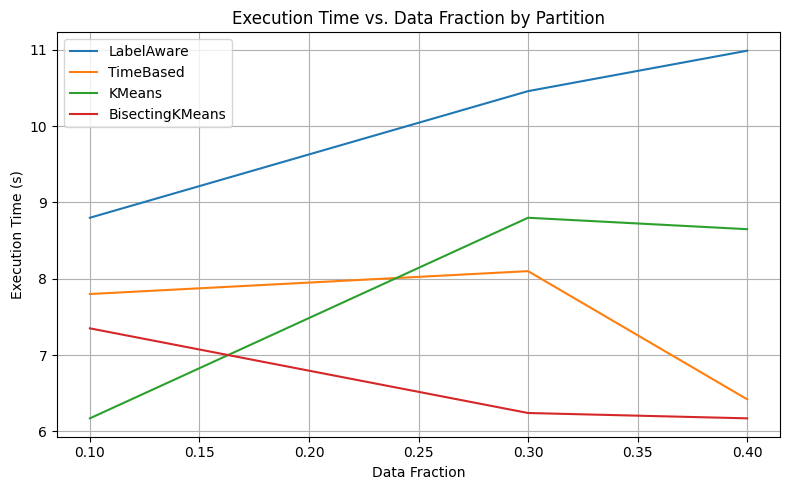

In [13]:
train_local_models()
run_local_smote_workflow()

### Different SMOTE Techniques Excecution
- **train_distributed()**
  - Trains Random Forest models using three global oversampling techniques:
    - SMOTE + ENN
    - Approximate SMOTE (LSH)
    - Exact Global SMOTE
  - Evaluates performance and saves results to CSV.

- **run_advanced_smote_workflow()**
  - Analyzes execution time of SMOTE techniques across different data fractions (10%–50%).
  - Includes:
    - Local SMOTE + ENN with KMeans
    - Approximate SMOTE (LSH)
    - Global SMOTE
  - Visualizes results with an execution time vs. data fraction plot.


In [14]:
def train_distributed():
    results = []

    kmeans_df = kmeans_partitioning(train_df_wo_time)
    smote_exact_global_instance = SMOTEExactGlobal(k=5)

    models = {
        "SMOTEENN":apply_enn_smote(train_df_wo_time, feature_cols),
        "LSH": approx_smote_lsh(train_df_wo_time),
        "SMOTEGlobal":smote_exact_global_instance.fit_transform(train_df_wo_time)
    }

    for name, model in models.items():
        print(f"Running {name}...")
        start = time.time()
        smote_df = model
        model_rf = train_random_forest(smote_df)
        metrics = evaluate_model(model_rf, test_df)
        results.append({"Model": name, **metrics})

        print(f"{name} : {metrics}")

    accuracy_df2 = pd.DataFrame(results)
    accuracy_df2.to_csv("more_smote_results.csv", index=False)
    print("Results saved to more_smote_results.csv")

    return results

def run_advanced_smote_workflow():
    results = []
    fractions = [0.1, 0.2, 0.3, 0.5]
    for frac in fractions:
        print(f"=== Fraction: {frac} ===")
        df = train_df.sample(withReplacement=False, fraction=frac, seed=42)

        features = feature_cols

        # print("Running Local SMOTE + ENN on KMeans...")
        # start = time.time()
        # kmeans_df = kmeans_partitioning(train_df_wo_time)
        # smote_enn_df = apply_enn_smote(kmeans_df,features)
        # duration = round(time.time() - start, 2)
        # print(f"KMeans + Local SMOTE + ENN Time: {duration}s")
        # results.append({"Method": "Local_SMOTE_ENN", "Fraction": frac, "Time": duration})

        print("Running Approximate SMOTE with LSH...")
        start = time.time()
        smote_lsh_df = approx_smote_lsh(train_df_wo_time)
        duration = round(time.time() - start, 2)
        print(f"Approximate SMOTE LSH Time: {duration}s")
        results.append({"Method": "Approx_SMOTE_LSH", "Fraction": frac, "Time": duration})

        print("Running SMOTE Global ...")
        start = time.time()
        # Call fit_transform instead of fit
        smote_exact_global_instance = SMOTEExactGlobal(k=5)
        smote_exact_df = smote_exact_global_instance.fit_transform(train_df_wo_time)
        duration = round(time.time() - start, 2)
        print(f"SMOTE Global) Time: {duration}s")
        results.append({"Method": "SMOTE_Global", "Fraction": frac, "Time": duration})

        print("Running SMOTE + ENN ...")
        start = time.time()
        smote_enn_df_global = apply_enn_smote(train_df_wo_time,features)
        duration = round(time.time() - start, 2)
        print(f"Local SMOTE + ENN Time: {duration}s")
        results.append({"Method": "Local_SMOTE_ENN", "Fraction": frac, "Time": duration})

    # Save results and plot
    results_df = pd.DataFrame(results)
    results_df.to_csv("advanced_smote_results.csv", index=False)
    print("Results saved to advanced_smote_results.csv")

    # Display results table
    print("\n=== Results Table ===")
    print(results_df)

    # Plot execution time vs. data fraction
    plt.figure(figsize=(8, 5))
    for part in results_df["Method"].unique():
        subset = results_df[results_df["Method"] == part]
        plt.plot(subset["Fraction"], subset["Time"], label=part)

    plt.xlabel("Data Fraction")
    plt.ylabel("Execution Time (s)")
    plt.title("Execution Time vs. Data Fraction by Partition")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Original minority count: 344
Majority count: 199020
Target total minority count (approx): 199020
Number of samples to generate: 198676
Collected 344 minority rows.
Looking for 5 nearest neighbors per minority point...
Neigher search completed
processing complete
Running SMOTEENN...
SMOTEENN : {'PR_AUC': 0.7269, 'ROC_AUC': 0.9833, 'Accuracy': 0.9939}
Running LSH...
LSH : {'PR_AUC': 0.7981, 'ROC_AUC': 0.9763, 'Accuracy': 0.9994}
Running SMOTEGlobal...
SMOTEGlobal : {'PR_AUC': 0.7252, 'ROC_AUC': 0.9727, 'Accuracy': 0.9955}
Results saved to more_smote_results.csv
=== Fraction: 0.1 ===
Running Approximate SMOTE with LSH...
Approximate SMOTE LSH Time: 23.73s
Running SMOTE Global ...
Original minority count: 344
Majority count: 199020
Target total minority count (approx): 199020
Number of samples to generate: 198676
Collected 344 minority rows.
Looking for 5 nearest neighbors per minority point...
Neigher search completed
processing complete
SMOTE Global) Time: 34.65s
Running SMOTE + ENN ...


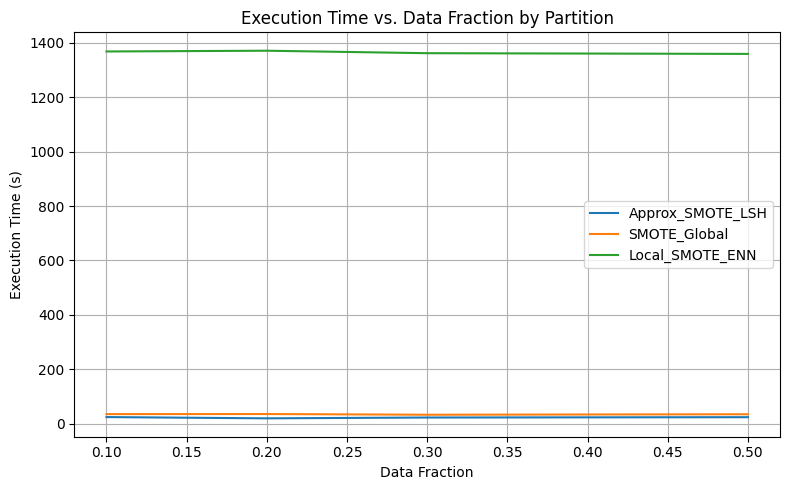

In [15]:
# Run workflows
# run_local_smote_workflow()
train_distributed()
run_advanced_smote_workflow()
# run_workflow()
